In [1]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import os
import datetime
import glob
import warnings
import cv2
import shutil
from PIL import Image 
warnings.filterwarnings("ignore")

In [2]:
#Importing the info related to the images
driver_details=pd.read_csv(r"Filtered_Dataset/driver_imgs_list.csv")
driver_details.shape

(22424, 3)

In [3]:
#Finding the wrong images in the dataset that are present inside the specific class folders irrespective of their representative
#behaviours
rm=[0,1,5,7,8,9]
rm_img=[]
for i in rm:
    for j in glob.glob("Filtered_Dataset/c"+str(i)+"_wrong/*.jpg"):
        rm_img.append(j.split("/")[2])

In [4]:
#Removing the images that are present in the folders irrespective of their representative behaviours
driver_details=driver_details[~driver_details["img"].isin(rm_img)]
driver_details.shape

(22234, 3)

In [5]:
#Printing a snippet of the driver_details remained after the removal of wrong images
driver_details.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
#Shape of driver_details dataframe representing the no of images to be dealt further
driver_details.shape

(22234, 3)

In [7]:
#Loading images seperately on Train, Val and Test dataframe based on the different ethnic groups
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

train_df = driver_details.loc[~driver_details['subject'].isin(['p014','p022','p050','p072'])]
val_df =  driver_details.loc[driver_details['subject'].isin(['p014','p050'])]
test_df  = driver_details.loc[driver_details['subject'].isin(['p022','p072'])]

In [8]:
#Converting dataframe into list
train_list=train_df.values.tolist()
val_list=val_df.values.tolist()
test_list=test_df.values.tolist()

In [9]:
#Merging validation and test list and saving the same into temp list and printing the length of the same
temp = val_list+test_list
import random
random.seed(42)
random.shuffle(temp)
len(temp)

3223

In [10]:
#Dividing the temp list by half and appending the last half to the train list while storing the first half into the test list
#This has been done to make model aware of all types of ethic groups on which it is really going to test
train_list.extend(temp[:len(temp)//2])
test_list = temp[len(temp)//2:]

In [11]:
#Making 10 different class folders before splitting the test and train dataset
base_dir = 'Dataset/'
os.makedirs(base_dir, exist_ok=True)

base_dir1 = 'Dataset1/'
os.makedirs(base_dir1, exist_ok=True)

train_dir = os.path.join(base_dir1, 'train2')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir1, 'test2')
os.makedirs(test_dir, exist_ok=True)

for i in range(10):
    train_dir_all_class = os.path.join(train_dir, 'c'+str(i))
    os.makedirs(train_dir_all_class, exist_ok=True)
    
for i in range(10):
    test_dir_all_class = os.path.join(test_dir, 'c'+str(i))
    os.makedirs(test_dir_all_class, exist_ok=True)

In [12]:
#Copying the images to the train dataset
for image in train_list:
    shutil.copyfile(base_dir+image[1]+'/'+image[2], train_dir+'/'+image[1]+'/'+image[2])

In [13]:
#Copying the images to the test dataset
for image in test_list:
    shutil.copyfile(base_dir+image[1]+'/'+image[2], test_dir+'/'+image[1]+'/'+image[2])

In [14]:
#Importing ImageDataGenerator and preprocess_input for image augumentation purpose and creating a train data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
train_data_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1,
      preprocessing_function=preprocess_input,
      validation_split=0.1)

In [15]:
#Creating the train and val generator object
train_gen = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(260,260),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_gen = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(260,260),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 18565 images belonging to 10 classes.
Found 2057 images belonging to 10 classes.


In [16]:
#Setting batch size, epochs, number of training and validation sequences 
batch_size=32
num_train_sequences = train_gen.samples
print('# training sequences =', num_train_sequences)
num_val_sequences = val_gen.samples
print('# val sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 18565
# val sequences = 2057
# epochs = 15


In [17]:
#Importing the EfficientNetB2 model
from efficientnet.tfkeras import EfficientNetB2

In [18]:
#Initilizing the efficientnetB2 model with pre-trained noisy-student weights
model_effntnetB2_conv = EfficientNetB2(weights= 'noisy-student',include_top=False, input_shape=(260,260,3))

In [19]:
#Importing tensorflow and keras libraries required for model building and training purpose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten,Dropout,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import optimizers

Using TensorFlow backend.


In [20]:
#Using the predefined EfficientNet model and further appending layers w.r.t. the no of classes present in the Driver Distraction Dataset 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

x = GlobalAveragePooling2D()(model_effntnetB2_conv.output)

final_pred = Dense(10, activation='softmax', name='predictions')(x)

effntnetB2_pretrained = Model(model_effntnetB2_conv.input, final_pred)

In [21]:
#EfficientNetB2 Model Summary
effntnetB2_pretrained.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 130, 130, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 130, 130, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 130, 130, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [22]:
# Compiling Pretrained Efficient model taking optimizer as Adam with default learning rate of 0.001, loss function as 
# categorical crossentropy and metric as accuracy
effntnetB2_pretrained.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])
effntnetB2_pretrained.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 130, 130, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 130, 130, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 130, 130, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [23]:
#Setting callback list using ReduceLROnPlateau, earlystopping and checkpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=2,
                                   min_lr=1e-4,
                                   verbose=1)

callbacks_list = [LR, checkpoint, earlystopping]

In [24]:
#Setting the size for steps per epoch and also the validation steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = ((num_train_sequences//batch_size) + 1)

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = ((num_val_sequences//batch_size) + 1)

In [25]:
#Model Generation
effntnetB2_pretrained.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_gen,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15
  2/581 [..............................] - ETA: 5:46 - loss: 2.3105 - accuracy: 0.1094  

W1107 10:25:32.037732 140694519576384 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4283s vs `on_train_batch_end` time: 0.7671s). Check your callbacks.


581/581 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.9032
Epoch 00001: val_accuracy improved from -inf to 0.97618, saving model to model_init_2020-11-0710_24_59.178705/model-00001-0.30536-0.08974-0.97618.h5
581/581 [==============================] - 778s 1s/step - loss: 0.3054 - accuracy: 0.9032 - val_loss: 0.0897 - val_accuracy: 0.9762
Epoch 2/15
581/581 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9720
Epoch 00002: val_accuracy improved from 0.97618 to 0.98250, saving model to model_init_2020-11-0710_24_59.178705/model-00002-0.09847-0.05574-0.98250.h5
581/581 [==============================] - 735s 1s/step - loss: 0.0985 - accuracy: 0.9720 - val_loss: 0.0557 - val_accuracy: 0.9825
Epoch 3/15
581/581 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9797
Epoch 00003: val_accuracy did not improve from 0.98250
581/581 [==============================] - 736s 1s/step - loss: 0.0679 - accuracy: 0.9797 - val_loss: 0

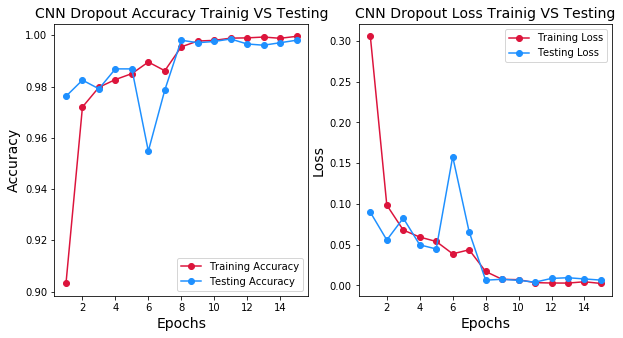

In [27]:
#Graphs between Accuracy vs epoch and loss vs epoch
from keras.callbacks import History as history
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(effntnetB2_pretrained.history.history["accuracy"]) + 1), effntnetB2_pretrained.history.history["accuracy"], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(effntnetB2_pretrained.history.history['val_accuracy']) + 1), effntnetB2_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(effntnetB2_pretrained.history.history['loss']) + 1), effntnetB2_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(effntnetB2_pretrained.history.history['val_loss']) + 1), effntnetB2_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [28]:
#Setting up the testing generator and initilizing the object for the same
test_data_generator = ImageDataGenerator(rescale=1./ 255, preprocessing_function=preprocess_input)
test_generator = test_data_generator.flow_from_directory(
        test_dir,
        target_size=(260,260),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
        ) 
test_generator.reset()

Found 1612 images belonging to 10 classes.


In [29]:
#Prediction on the test dataset
Y_pred = effntnetB2_pretrained.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
print(sum(y_pred==classes)/test_generator.samples)

#Confusion Matrix on the Test Dataset
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred)

0.9981389578163772


array([[216,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 184,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2, 174,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 167,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 183,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 158,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 178,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 116,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 101,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 132]])